#Dataset Download

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"m168dsx2576","key":"3b0948d070a685ba27a3d13fe646a8cd"}'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d 'kuuha2768/rotten-fruit-dataset'

100% 2.07G/2.07G [02:19<00:00, 13.4MB/s]
100% 2.07G/2.07G [02:19<00:00, 16.0MB/s]


# Data Preparation

In [ ]:
# grader-required-cell

import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from shutil import copyfile
import matplotlib.pyplot as plt
import tensorflow_hub as hub

In [ ]:
dataset_zip = zipfile.ZipFile('rotten-fruit-dataset.zip', 'r')
dataset_zip.extractall()
dataset_zip.close()

In [ ]:
dataset_dir='dataset'
train_dir = 'dataset/train/'
validation_dir = 'dataset/test/'

training_fresh_apples_dir = os.path.join(train_dir, 'freshapples/')
training_fresh_banana_dir = os.path.join(train_dir, 'freshbanana/')
training_fresh_oranges_dir = os.path.join(train_dir, 'freshoranges/')
training_rotten_apples_dir = os.path.join(train_dir, 'rottenapples/')
training_rotten_banana_dir = os.path.join(train_dir, 'rottenbanana/')
training_rotten_oranges_dir = os.path.join(train_dir, 'rottenoranges/')

validation_fresh_apples_dir = os.path.join(validation_dir, 'freshapples/')
validation_fresh_banana_dir = os.path.join(validation_dir, 'freshbanana/')
validation_fresh_oranges_dir = os.path.join(validation_dir, 'freshoranges/')
validation_rotten_apples_dir = os.path.join(validation_dir, 'rottenapples/')
validation_rotten_banana_dir = os.path.join(validation_dir, 'rottenbanana/')
validation_rotten_oranges_dir = os.path.join(validation_dir, 'rottenoranges/')

In [ ]:
print("TRAINING DATA SET")

print(f"There are {len(os.listdir(training_fresh_apples_dir))} images of fresh apples for training")
print(f"There are {len(os.listdir(training_fresh_banana_dir))} images of fresh banana for training")
print(f"There are {len(os.listdir(training_fresh_oranges_dir))} images of fresh oranges for training")
print(f"There are {len(os.listdir(training_rotten_apples_dir))} images of rotten apples for training")
print(f"There are {len(os.listdir(training_rotten_banana_dir))} images of rotten banana for training")
print(f"There are {len(os.listdir(training_rotten_oranges_dir))} images of rotten oranges for training")

print("\nVALIDATION DATA SET \n")
print(f"There are {len(os.listdir(validation_fresh_apples_dir))} images of fresh apples for validation")
print(f"There are {len(os.listdir(validation_fresh_banana_dir))} images of fresh banana for validation")
print(f"There are {len(os.listdir(validation_fresh_oranges_dir))} images of fresh oranges for validation")

print(f"There are {len(os.listdir(validation_rotten_apples_dir))} images of rotten apples for validation")
print(f"There are {len(os.listdir(validation_rotten_banana_dir))} images of rotten banana for validation")
print(f"There are {len(os.listdir(validation_rotten_oranges_dir))} images of rotten oranges for validation")

TRAINING DATA SET
There are 1693 images of fresh apples for training
There are 1581 images of fresh banana for training
There are 2166 images of fresh oranges for training
There are 2342 images of rotten apples for training
There are 2224 images of rotten banana for training
There are 2295 images of rotten oranges for training

VALIDATION DATA SET 

There are 734 images of fresh apples for validation
There are 698 images of fresh banana for validation
There are 982 images of fresh oranges for validation
There are 1070 images of rotten apples for validation
There are 824 images of rotten banana for validation
There are 1022 images of rotten oranges for validation


# class generator


In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    train_data = ImageDataGenerator(rescale=1/255)
    train_generator = train_data.flow_from_directory(directory=train_dir,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))

    validation_data = ImageDataGenerator(rescale=1/255)
    validation_generator = validation_data.flow_from_directory(directory=validation_dir,
                                                              batch_size=32,
                                                              class_mode='categorical',
                                                              target_size=(224, 224))

    return train_generator, validation_generator



In [ ]:
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 12301 images belonging to 6 classes.
Found 5330 images belonging to 6 classes.


In [ ]:
labels = train_generator.class_indices
train_generator.class_indices

{'freshapples': 0,
 'freshbanana': 1,
 'freshoranges': 2,
 'rottenapples': 3,
 'rottenbanana': 4,
 'rottenoranges': 5}

In [ ]:
validation_generator.class_indices

{'freshapples': 0,
 'freshbanana': 1,
 'freshoranges': 2,
 'rottenapples': 3,
 'rottenbanana': 4,
 'rottenoranges': 5}

#data augmentation

In [ ]:
!pip install -U albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 10.7 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-h85oz4q8
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-h85oz4q8
  Resolved https://github.com/albumentations-team/albumentations to commit 30deec1ee4f3bf8e56c43baa894de970e609852b
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -U albumentations --no-binary qudida,albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import albumentations as A
import cv2
import glob
from PIL import Image
import numpy as np
import tensorflow as tf

train_transform = A.Compose([
    A.Rotate(limit=30, p=0.5),
    A.RandomScale(scale_limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.Flip(p=0.5),
    A.RandomCrop(height=224, width=224),
    A.ChannelShuffle(p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
])


In [ ]:
def albumentations_generator(generator, transform):
    for images, labels in generator:
        transformed_images = []
        for image in images:
            transformed = transform(image=image)
            transformed_images.append(transformed['image'])
        yield np.array(transformed_images), labels


In [ ]:
augmented_train_generator = albumentations_generator(train_generator, train_transform)


In [ ]:
augmented_train_generator_test= train_val_generators(augmented_train_generator, validation_dir)

Found 12301 images belonging to 6 classes.
Found 5330 images belonging to 6 classes.


# Building Model

In [ ]:
#building the model

model = tf.keras.models.Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))


In [ ]:
import math

total_samples = len(train_generator) * train_generator.batch_size
steps_per_epoch = math.ceil(total_samples / 32)

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#evaluate model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(train_generator,
                    epochs=20,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_generator,
                    callbacks=[early_stopping])

Epoch 1/20
385/385 [==============================] - 107s 238ms/step - loss: 0.6674 - accuracy: 0.7619 - val_loss: 0.2873 - val_accuracy: 0.9017
Epoch 2/20
385/385 [==============================] - 76s 198ms/step - loss: 0.2717 - accuracy: 0.9025 - val_loss: 0.1851 - val_accuracy: 0.9356
Epoch 3/20
385/385 [==============================] - 76s 197ms/step - loss: 0.1898 - accuracy: 0.9324 - val_loss: 0.1308 - val_accuracy: 0.9565
Epoch 4/20
385/385 [==============================] - 73s 189ms/step - loss: 0.1290 - accuracy: 0.9556 - val_loss: 0.1353 - val_accuracy: 0.9582
Epoch 5/20
385/385 [==============================] - 75s 195ms/step - loss: 0.1103 - accuracy: 0.9629 - val_loss: 0.1221 - val_accuracy: 0.9674
Epoch 6/20
385/385 [==============================] - 93s 242ms/step - loss: 0.0780 - accuracy: 0.9725 - val_loss: 0.1081 - val_accuracy: 0.9600
Epoch 7/20
385/385 [==============================] - 75s 194ms/step - loss: 0.0691 - accuracy: 0.9762 - val_loss: 0.1089 - val_a

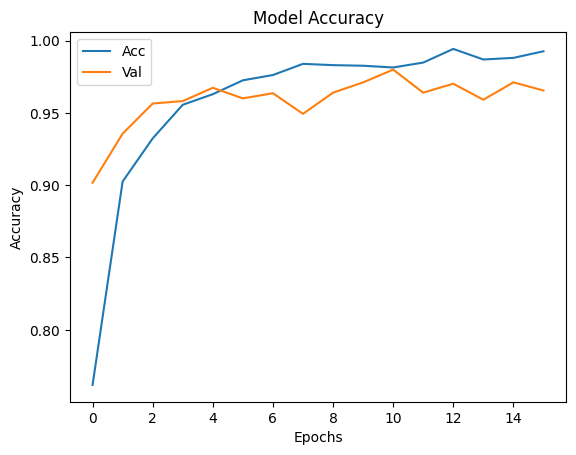

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Acc', 'Val'], loc='upper left')

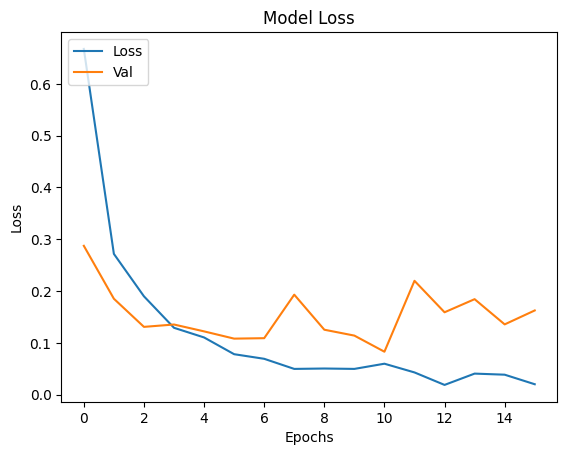

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Val'], loc='upper left')

In [ ]:
loss, accuracy = model.evaluate(validation_generator)

167/167 [==============================] - 22s 131ms/step - loss: 0.0828 - accuracy: 0.9799


In [ ]:
def Result(classes):
  values=[]
  max_index = 0
  max_value = 0
  i = 0
  for numbers in classes:
    for number in numbers:
      values.append(number)

  for value in values:
    if value > max_value:
      max_value = value
      max_index = i
    i+=1

  return max_index

In [ ]:
savepath = "/content/drive/MyDrive/history"
os.makedirs(savepath, exist_ok=True)

Saving depositphotos_12915976-stock-photo-rotten-orange-isolated-on-white.jpg to depositphotos_12915976-stock-photo-rotten-orange-isolated-on-white.jpg
1/1 [==============================] - 0s 206ms/step
The fruit is 60.414% rottenoranges


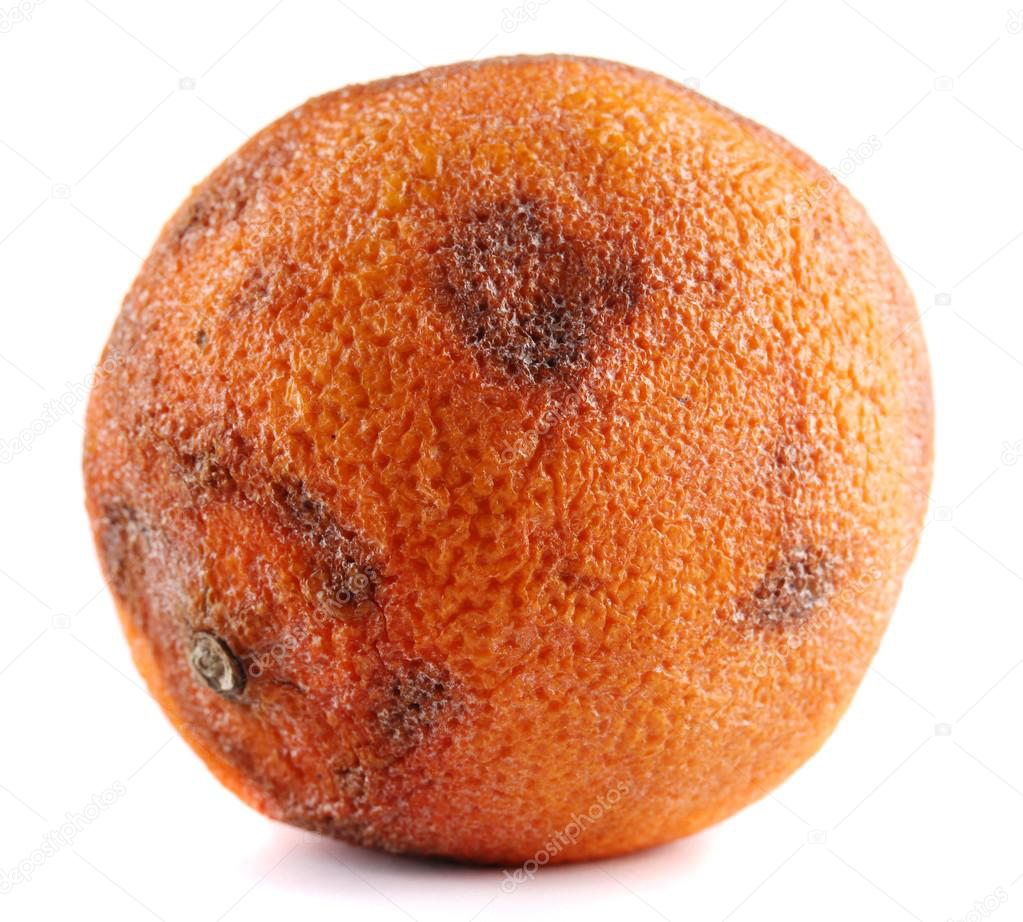

In [ ]:
# Load and preprocess the image

uploaded = files.upload()

for fn in uploaded.keys():
    # Predicting images
    path = '/content/' + fn
    print_image = Image.open(path)
    resized_image = print_image.resize((224, 224), resample=Image.BILINEAR)
    rgb_image = resized_image.convert("RGB")
    normalized_image = np.array(rgb_image) / 255.0
    image_array = np.array(normalized_image)
    image_array = np.expand_dims(normalized_image, axis=0)

    classes = model.predict(image_array, batch_size=10)
    class_index = np.argmax(classes[0])
    predicted_percent = classes[0][class_index] * 100

    # Convert class indices to labels dictionary
    labels_dict = {v: k for k, v in train_generator.class_indices.items()}

    # Get the predicted class label
    predicted_label = labels_dict[class_index]

    # Print the result
    print("The fruit is {:.3f}% {}".format(predicted_percent, predicted_label))
    print_image.show()
    image_name = predicted_label + os.path.splitext(fn)[1]
    save_name = os.path.join(savepath, image_name)
    print_image.save(save_name)


#Save Model

## Size Function


In [ ]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [ ]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

#TFlite Model


In [ ]:
# convert model to tflite
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

In [ ]:
# Save the TFLite model to a file
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

88717548

In [ ]:
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "MB")


File size: 84.608 Megabytes
